## Transfermarkt / Sofifa experiments

1. Driver code to get player stats and data from TM and SF by webscraping
2. Experimental heuristics and plots for analyzing player "value"
3. Use above player value to analyze best possible starting 11 for a team

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import math
import operator

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [6]:
def tmplayerlinks(teamurl):
    """
    Get TM links players
    Params:
    - teamurl : 
        - str. link to team. 
        - https://www.transfermarkt.de/eintracht-frankfurt/startseite/verein/24'
    Returns:
    - playerurls : 
        - set. list of players. 
        - {/ante-rebic/profil/spieler/187587', '/branimir-hrgota/profil/spieler/171209' ..}
    """
    r = requests.get(teamurl, headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    playerurls = []
    for i in soup.find_all('td', 'hauptlink'):
        j = i.find('a')
        if j:
            p = j.get('href')
            if 'profil/spieler' in p:
                playerurls.append(p)
    return set(playerurls)

tmplayerlinks('https://www.transfermarkt.de/eintracht-frankfurt/startseite/verein/24')

{'/allan/profil/spieler/385271',
 '/ante-rebic/profil/spieler/187587',
 '/branimir-hrgota/profil/spieler/171209',
 '/carlos-salcedo/profil/spieler/256866',
 '/chico-geraldes/profil/spieler/257456',
 '/danny-da-costa/profil/spieler/85906',
 '/david-abraham/profil/spieler/58178',
 '/deji-beyreuther/profil/spieler/482163',
 '/evan-ndicka/profil/spieler/371149',
 '/felix-wiedwald/profil/spieler/44594',
 '/filip-kostic/profil/spieler/161011',
 '/frederik-ronnow/profil/spieler/107775',
 '/gelson-fernandes/profil/spieler/20081',
 '/goncalo-paciencia/profil/spieler/181547',
 '/jan-zimmermann/profil/spieler/10917',
 '/jetro-willems/profil/spieler/146258',
 '/jonathan-de-guzman/profil/spieler/31067',
 '/kevin-trapp/profil/spieler/45672',
 '/lucas-torro/profil/spieler/213670',
 '/luka-jovic/profil/spieler/257462',
 '/makoto-hasebe/profil/spieler/39259',
 '/marc-stendera/profil/spieler/160943',
 '/marco-fabian/profil/spieler/67685',
 '/marco-russ/profil/spieler/16520',
 '/mijat-gacinovic/profil/sp

In [4]:
def parsetmvalue(value):
    # Read German value and covert to float
    # >>> parsetmvlue('3,5 Mio') = 3500000
    x = value.split()
    millions = {'Mio.':1, 'Tsd.':0.001}
    return float(x[0].replace(',','.')) * millions[x[1]]
    
def parsesfvalue(value):
    # Read sofifa value and convert to float
    # >>> parsesfvalue(3.5M) = 3500000
    millions = {'M':1, 'K':0.001}
    return float(value[1:-1]) * millions[value[-1]]

def parsetmpositions(positions):
    pos = {
        'Torwart': 'GK', 
        'Rechter Verteidiger': 'RB', 'Linker Verteidiger': 'LB', 
        'Innenverteidiger': 'CB',
        'Zentrales Mittelfeld': 'CM', 
        'Defensives Mittelfeld':'CDM',
        'Offensives Mittelfeld': 'CAM', 
        'Linkes Mittelfeld': 'LM', 'Rechtes Mittelfeld': 'RM',
        'Linksaußen': 'LW', 'Rechtsaußen':'RW',
        'Hängende Spitze': 'CF', 'Mittelstürmer': 'ST'
    }
    return [pos.get(x) for x in positions]

In [ ]:
def getsfdata(name): 
    """
    Get player data from sofifa
    """
    r = requests.get('https://sofifa.com/players?keyword=' + name.replace(' ','+') , headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    try:
        positions = soup.find('div', 'text-clip rtl').get_text().split()
        rating = int(soup.find('div', 'col-digit col-oa').get_text())
        potential = int(soup.find('div', 'col-digit col-pt').get_text())
        value = soup.find('div', 'col-digit col-vl').get_text().strip()
        return positions, rating, potential, parsesfvalue(value)
    except:
        return None, None, None, None

getsfdata('Sven Ulreich')

In [7]:
def gettmdata(player):
    """
    Get player data from TM
    """
    r = requests.get('http://www.transfermarkt.de' + player, headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')

    name = soup.find('h1').get_text().strip()
    mval = soup.find('div','dataMarktwert') 
    value = mval.get_text().strip()

    for i in soup.find_all('div', 'spielerdaten'):
        rows = i.find_all('tr')
        for cols in rows:
            key = cols.find('th').get_text().strip()
            if key=='Aktueller Verein:':
                club = cols.find('td').get_text().strip()
            
    for i in soup.find_all('div', 'detailpositionen'):
        hp = i.find('div', re.compile('hauptposition*'))
        hptext = hp.get_text(strip=True, separator=',').split(',')[1:]
        np = i.find('div', 'nebenpositionen')
        try:
            nptext = np.get_text(strip=True, separator=',').split(',')[1:]
        except:
            nptext = []
            
        positions = hptext + nptext
    
    return name, club, parsetmvalue(value), parsetmpositions(positions)

gettmdata('/thomas-muller/profil/spieler/58358')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


('Thomas Müller', 'FC Bayern München', 55.0, ['CF', 'RW', 'CAM'])

In [ ]:
def getdata(player):
    """
    Combind SF and TM data
    """
    name, club, tmvalue, tmpositions = gettmdata(player)
    sfpositions, sfrating, sfpotential, sfvalue = getsfdata(name)
    print(name, 'DONE')
    return name, club, tmvalue, tmpositions, sfpositions, sfrating, sfpotential, sfvalue

getdata('/thiago/profil/spieler/60444')

In [141]:
teamurl = 'https://www.transfermarkt.de/vfl-wolfsburg/startseite/verein/82'
playerurls = tmplayerlinks(teamurl)

playerdata = []
for i in playerurls:
    playerdata.append(getdata(i))

Elvis Rexhbecaj DONE
Divock Origi DONE
Josip Brekalo DONE
Sebastian Jung DONE
Kaylen Hinds DONE
Jeffrey Bruma DONE
Daniel Didavi DONE
Max Grün DONE
Renato Steffen DONE
Phillip Menzel DONE
Koen Casteels DONE
Ohis Felix Uduokhai DONE
Paul Verhaegh DONE
Yannick Gerhardt DONE
William DONE
John Anthony Brooks DONE
Riechedly Bazoer DONE
Maximilian Arnold DONE
Gian-Luca Itter DONE
Mario Gómez DONE
Yunus Malli DONE
Jakub Blaszczykowski DONE
Victor Osimhen DONE
Robin Knoche DONE
Ignacio Camacho DONE
Josuha Guilavogui DONE
Landry Dimata DONE
Marcel Tisserand DONE
Justin Möbius DONE


In [142]:
playerdata

[('Elvis Rexhbecaj',
  'VfL Wolfsburg II',
  0.2,
  ['CDM', 'CB', 'CAM'],
  ['CM'],
  63,
  75,
  0.625),
 ('Divock Origi',
  'VfL Wolfsburg',
  12.0,
  ['ST', 'LW', 'RW'],
  ['ST', 'LW', 'RM'],
  78,
  85,
  15.0),
 ('Josip Brekalo',
  'VfL Wolfsburg',
  3.5,
  ['LW', 'RW', 'CF'],
  ['LM', 'RM'],
  73,
  83,
  6.5),
 ('Sebastian Jung', 'VfL Wolfsburg', 1.0, ['RB'], ['RB'], 74, 75, 5.0),
 ('Kaylen Hinds',
  'VfL Wolfsburg',
  1.25,
  ['CF', 'ST', 'CAM'],
  ['CF', 'LM'],
  61,
  78,
  0.55),
 ('Jeffrey Bruma', 'VfL Wolfsburg', 8.0, ['CB', 'RB'], ['CB'], 78, 82, 11.5),
 ('Daniel Didavi',
  'VfL Wolfsburg',
  7.0,
  ['CAM', 'LW', 'RW'],
  ['CAM', 'CM'],
  81,
  82,
  20.5),
 ('Max Grün',
  'VfL Wolfsburg',
  0.25,
  ['GK'],
  ['GK'],
  68,
  68,
  0.5750000000000001),
 ('Renato Steffen',
  'VfL Wolfsburg',
  3.5,
  ['RM', 'LM', 'RW'],
  ['LM', 'RM', 'CAM'],
  77,
  78,
  10.5),
 ('Phillip Menzel', 'VfL Wolfsburg', 0.15, ['GK'], ['GK'], 59, 77, 0.26),
 ('Koen Casteels', 'VfL Wolfsburg', 3.

In [143]:
tdf = pd.DataFrame(columns=['name', 'tmmv', 'tmpos','sfpos','sfovr','sfmv'])
for p in playerdata:
    tdf = tdf.append({'name':p[0], 
                      'tmmv':p[2],
                      'tmpos':p[3],
                      'sfpos':p[4],
                      'sfovr':p[5],
                      'sfmv':p[7]},
                      ignore_index=True)
tdf

,name,tmmv,tmpos,sfpos,sfovr,sfmv
0,Elvis Rexhbecaj,0.20,"[CDM, CB, CAM]",[CM],63,0.625
1,Divock Origi,12.00,"[ST, LW, RW]","[ST, LW, RM]",78,15
2,Josip Brekalo,3.50,"[LW, RW, CF]","[LM, RM]",73,6.5
3,Sebastian Jung,1.00,[RB],[RB],74,5
4,Kaylen Hinds,1.25,"[CF, ST, CAM]","[CF, LM]",61,0.55
5,Jeffrey Bruma,8.00,"[CB, RB]",[CB],78,11.5
6,Daniel Didavi,7.00,"[CAM, LW, RW]","[CAM, CM]",81,20.5
7,Max Grün,0.25,[GK],[GK],68,0.575
8,Renato Steffen,3.50,"[RM, LM, RW]","[LM, RM, CAM]",77,10.5
9,Phillip Menzel,0.15,[GK],[GK],59,0.26


In [ ]:
#df.sort_values(by='rating').plot(kind='bar')
#plt.show()

In [129]:
Edge Cases ::
#Bayern
'''playerdata.remove(('Rafinha','FC Bayern München',3.5,['RB', 'RM', 'LB'], ['CM', 'RM', 'RW'], 81,  86,23.5))
playerdata.append(('Rafinha','FC Bayern München',3.5,['RB', 'RM', 'LB'],['RB', 'CB', 'LB'], 78,78,7))'''

#Dortmund
'''playerdata.remove(('Lukasz Piszczek','Borussia Dortmund',4.0,['RB', 'RM', 'CB'],None,None,None,None))
playerdata.append(('Lukasz Piszczek','Borussia Dortmund',4.0,['RB', 'RM', 'CB'],['RB','CB'],83,83,14.5))'''

#Schalke
'''playerdata.remove(('Naldo', 'FC Schalke 04', 1.5, ['CB'], ['LW', 'ST'], 94, 94, 95.5))
playerdata.append(('Naldo', 'FC Schalke 04', 1.5, ['CB'], ['CB'], 83, 83, 8))'''

#Leverkusen

#Leipzig
'''playerdata.remove(('Bernardo','RasenBallsport Leipzig',6.0,['LB', 'RB', 'CDM'],['RM'],84,90,42.5))
playerdata.append(('Bernardo','RasenBallsport Leipzig',6.0,['LB', 'RB', 'CDM'],['RB','LB'],74,81,6.5))'''

#Gladbach
'''playerdata.remove(('Michaël Cuisance','Borussia Mönchengladbach',3.5,['CM', 'CDM'],None,None,None,None))
playerdata.append(('Michaël Cuisance','Borussia Mönchengladbach',3.5,['CM', 'CDM'],['CM'],68,84,1.8))'''

#Wolfsburg


#Arsenal
'''playerdata.remove(('Matt Macey', 'FC Arsenal', 0.5, ['GK'], None, None, None, None))'''

#Eintracht
'''playerdata.remove(('Nelson Mandela Mbouhom','Eintracht Frankfurt',0.1,['CF', 'LW', 'CAM'],None,None,None,None))
playerdata.remove(('Noel Knothe', 'Eintracht Frankfurt', 0.1, ['CB'], None, None, None, None))
playerdata.remove(('Branimir Hrgota','Eintracht Frankfurt',1.75,[None, None, None],['ST', 'LM'],72,78,4.3))
playerdata.append(('Branimir Hrgota','Eintracht Frankfurt',1.75,['ST', 'RW', 'CF'],['ST', 'LM'],72,78,4.3))
playerdata.remove(('Timothy Chandler','Eintracht Frankfurt',3.5,['RB', 'RM'],None,None,None,None))
playerdata.remove(('Deji Beyreuther','Eintracht Frankfurt',0.1,['LB'],None,None,None,None))
playerdata.append(('Timothy Chandler','Eintracht Frankfurt',3.5,['RB', 'RM'],['RB','RWB','RM'],76,77,7))
playerdata.append(('Deji Beyreuther','Eintracht Frankfurt',0.1,['LB'],['LB'],60,78,0.375))'''

"playerdata.remove(('Nelson Mandela Mbouhom','Eintracht Frankfurt',0.1,['CF', 'LW', 'CAM'],None,None,None,None))\nplayerdata.remove(('Noel Knothe', 'Eintracht Frankfurt', 0.1, ['CB'], None, None, None, None))\nplayerdata.remove(('Branimir Hrgota','Eintracht Frankfurt',1.75,[None, None, None],['ST', 'LM'],72,78,4.3))\nplayerdata.append(('Branimir Hrgota','Eintracht Frankfurt',1.75,['ST', 'RW', 'CF'],['ST', 'LM'],72,78,4.3))\nplayerdata.remove(('Timothy Chandler','Eintracht Frankfurt',3.5,['RB', 'RM'],None,None,None,None))\nplayerdata.remove(('Deji Beyreuther','Eintracht Frankfurt',0.1,['LB'],None,None,None,None))\nplayerdata.append(('Timothy Chandler','Eintracht Frankfurt',3.5,['RB', 'RM'],['RB','RWB','RM'],76,77,7))\nplayerdata.append(('Deji Beyreuther','Eintracht Frankfurt',0.1,['LB'],['LB'],60,78,0.375))"

# Value Heuristics

In [131]:
df = pd.DataFrame(columns=['name', 'position', 'score'])


MAXSF = 95
MINSF = 60

for i in playerdata:
    name = i[0] #.split()[-1]
    value = math.sqrt((i[2] + i[7])/2)
    rating = (i[5]-MINSF)/(MAXSF-MINSF) * 10
    mainpos = set([i[3][0]] + [i[4][0]])
    secpos = set(i[3][1:] + i[4][1:]) - mainpos

    if value-rating>=2:
        score = (3*value + rating)/4
    elif rating-value>=2:
        score = (value + 3*rating)/4
    else:
        score = (value + 2*rating)/3
    
    for p in mainpos:
        df = df.append({'name':name, 
                    #'value':value, 
                    #'rating':rating, 
                    'position':p, 
                    'score':score}, 
                    ignore_index=True)
    
    for p in secpos:
         df = df.append({'name':name, 
                        'position':p, 
                        'score':0.7*score}, 
                        ignore_index=True)

#df 
#df.sort_values(by='score')

In [132]:
def getpositionslist(df, formation):
    if formation=='4231':
        positions = [['GK'],
                     ['RB'],
                     ['CB'],
                     ['CB'],
                     ['LB'],
                     ['CDM','CM'],
                     ['CDM','CM'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CF','ST']]
        
    elif formation=='4321':
        positions = [['GK'],
                     ['RB'],
                     ['CB'],
                     ['CB'],
                     ['LB'],
                     ['CDM','CM'],
                     ['CDM','CM'],
                     ['CM','CAM'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CF','ST']]
        
    elif formation=='4222':
        positions = [['GK'],
                     ['RB'],
                     ['CB'],
                     ['CB'],
                     ['LB'],
                     ['CDM','CM'],
                     ['CDM','CM'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CF','ST'],
                     ['CF','ST']]  
    
    elif formation=='3421':
        positions = [['GK'],
                     ['CB'],
                     ['CB'],
                     ['CB','RB','LB'],
                     ['RB','RM'],
                     ['CDM','CM'],
                     ['CDM','CM'],
                     ['LB','LM'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CF','ST']]  
    
    elif formation=='3412':
        positions = [['GK'],
                     ['CB'],
                     ['CB'],
                     ['CB','RB','LB'],
                     ['RB','RM'],
                     ['CDM','CM'],
                     ['CDM','CM'],
                     ['LB','LM'],
                     ['CAM','RM','LM','RW','LW','CF'],
                     ['CF','ST'],
                     ['CF','ST']]  

    positionslist = []
    for p in positions:
        pdf = df[df['position'].isin(p)].sort_values(by='score')
        positionslist.append(pdf.values.tolist())
        #print(pdf)
    return positionslist

#positionslist = getpositionslist(df, '4231'):

In [133]:
def printlen(positionslist):
    print(len(positionslist))
    p = [len(x) for x in positionslist]
    print(sum(p))
    print(p)

#printlen(positionslist)

In [134]:
#df[df['position'].isin(['CB'])].sort_values(by='score')

In [135]:
def getmax(positionslist, done):
    bestscore = -1
    besti = 0
    for i in range(11):
        if done[i]==0:
            #print(positionslist[i][-1])
            score = positionslist[i][-1][2]
            if score>bestscore:
                bestscore = score
                besti = i
            elif abs(score-bestscore)<0.00001:
                if score-positionslist[i][-2][2] < score-positionslist[besti][-2][2]:
                    besti = i                    
                
                
    return besti, positionslist[besti][-1][0]

#getmax(positionslist, [0]*11)

In [136]:
def deleteplayer(positionslist, name):
    l = []
    for i in range(11):
        l.append([x for x in positionslist[i] if x[0]!=name])
    return l

#positionslist = deleteplayer(positionslist, 'Kingsley Coman')

In [137]:
def getbestteam(positionslist): 
    team = ['']*11
    done = [0]*11
    while done!=[1]*11:
        besti, best = getmax(positionslist, done)
        team[besti] = best
        done[besti] = 1
        positionslist = deleteplayer(positionslist, best)            
        #printlen(positionslist)
        #print(positionslist)
        #print(team) #,done
    return team, positionslist

In [138]:
def gettotalscore(team, allpos):
    total = 0
    for i in range(11):
        for j in range(len(allpos[i])-1,-1,-1):
            if allpos[i][j][0]==team[i]:
                #print(allpos[i][j])
                total += allpos[i][j][2]
                break
    return total

#gettotalscore(team1, allpos)

In [139]:
def prettyprintteam(team, formation):
    team = [x.split()[-1] for x in team]
    d = int(formation[0])
    m = int(formation[1])
    amf = int(formation[2])
    f = int(formation[3])
    
    print(team[0])
    print(*team[1:d+1])
    print(*team[d+1:d+m+1])
    print(*team[d+m+1:d+m+amf+1])
    print(*team[d+m+amf+1:d+m+amf+f+1])

In [140]:
formations = ['4231','4321','4222','3421','3412']

forscores = {}
forteams = {}
for f in formations:    
    positionslist = getpositionslist(df, f)
    allpos = positionslist
    team1, positionslist = getbestteam(positionslist)
    #prettyprintteam(team1, f)
    #print(gettotalscore(team1, allpos))
    forscores[f] = gettotalscore(team1, allpos)
    forteams[f] = team1

    
bestfor1 = sorted(forscores.items(), key=operator.itemgetter(1))[-1][0]
bestteam1 = forteams[bestfor1]
prettyprintteam(bestteam1, bestfor1)

forscores = {}
forteams = {}
for f in formations:
    try:
        positionslist = getpositionslist(df, f)
        for p in bestteam1:
            positionslist = deleteplayer(positionslist, p)
        allpos = positionslist
        team2, positionslist = getbestteam(positionslist)
        forscores[f] = gettotalscore(team2, allpos)
        forteams[f] = team2
    except:
        continue

try:
    print('\n')
    print(forteamss)
    bestfor2 = sorted(forscores.items(), key=operator.itemgetter(1))[-1][0]
    bestteam2 = forteams[bestfor2]
    prettyprintteam(forteams[bestfor2],  bestfor2)
except:
    pass

others = []
for p in playerdata:
    if p[0] not in bestteam1+bestteam2:
        others.append(p[0].split()[-1])

print('\n')
print(*others)

Sommer
Elvedi Ginter Vestergaard Wendt
Kramer Zakaria
Stindl Hazard
Raffael Bobadilla




Simakala Nicolas Hofmann Doucouré Sippel Drmic Benger Villalba Traoré Bénes Strobl Herrmann Grifo Jantschke Yeboah Johnson Cuisance


In [110]:
bestteam2

['Michael Langer',
 'Pablo Insua',
 'Sascha Riether',
 'Thilo Kehrer',
 'Alessandro Schöpf',
 'Max Meyer',
 'Weston McKennie',
 'Bernard Tekpetey',
 'Amine Harit',
 'Marko Pjaca',
 'Franco Di Santo']

In [265]:
gdf = df.groupby('position')
for key, item in gdf:
    print(gdf.get_group(key))
    print('\n')

               name position     score
12     Fabian Benko      CAM  0.401295
24  James Rodríguez      CAM  7.379084
35           Thiago      CAM  5.544487
39     Arturo Vidal      CAM  4.827222
48    Thomas Müller      CAM  5.053505
67    Franck Ribéry      CAM  4.362500


              name position     score
0      Felix Götze       CB  0.798120
4      Niklas Süle       CB  6.214286
21   Javi Martínez       CB  4.445659
40  Jérôme Boateng       CB  7.480683
43    Marco Friedl       CB  0.884930
50  Joshua Kimmich       CB  4.437190
54     David Alaba       CB  4.965277
56    Mats Hummels       CB  7.544417
72         Rafinha       CB  3.100975


                name position     score
1        Felix Götze      CDM  0.558684
5     Sebastian Rudy      CDM  5.394433
18  Corentin Tolisso      CDM  4.318673
20     Javi Martínez      CDM  6.350942
36            Thiago      CDM  5.544487
37      Arturo Vidal      CDM  6.896032
44      Marco Friedl      CDM  0.884930
51    Joshua Kimmich   

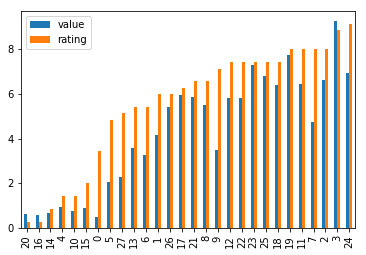

In [93]:
allpos

[[['Niklas Lomb', 'GK', 1.363336418779192],
  ['Ramazan Özcan', 'GK', 3.5633917153799377]],
 [['Benjamin Henrichs', 'CB', 2.924605164697948],
  ['Panagiotis Retsos', 'CB', 3.630891014569728]],
 [['Benjamin Henrichs', 'CB', 2.924605164697948],
  ['Panagiotis Retsos', 'CB', 3.630891014569728]],
 [['Panagiotis Retsos', 'LB', 2.5416237101988095],
  ['Panagiotis Retsos', 'RB', 2.5416237101988095],
  ['Benjamin Henrichs', 'LB', 2.924605164697948],
  ['Benjamin Henrichs', 'CB', 2.924605164697948],
  ['Dominik Kohr', 'RB', 3.0212019206242684],
  ['Panagiotis Retsos', 'CB', 3.630891014569728],
  ['Benjamin Henrichs', 'RB', 4.178007378139926],
  ['Wendell', 'LB', 4.3807043381620785]],
 [['Panagiotis Retsos', 'RB', 2.5416237101988095],
  ['Dominik Kohr', 'RB', 3.0212019206242684],
  ['Julian Baumgartlinger', 'RM', 3.1196352582898625],
  ['Admir Mehmedi', 'RM', 4.053571428571429],
  ['Kai Havertz', 'RM', 4.148137305878663],
  ['Benjamin Henrichs', 'RB', 4.178007378139926]],
 [['Marlon Frey', 'CM',